# Modèle démographique

In [139]:
import numpy as np 
from numba import njit
from matplotlib import pyplot as plt
import pandas as pd
from functools import partial
from multiprocessing import Pool as pool
from importlib import reload

## Les acteurs

Nous définissons une individu de référence par des caractéristiques de numéro d'assurance sociale, $i$, d'année de naissance, $b$, le sexe $s$ et niveau d'éducation, $e$. Nous définissons aussi des conjoints (avec moins de caractéristiques) et des enfants... Les enfants d'un individu sont seulement ceux qui résident à la maison. Nous supposons un départ à 18 ans. Un petit exemple réel... (sans les NAS)

In [140]:
from tools import actors
reload(actors)

<module 'tools.actors' from '/Volumes/Tapageur/Dropbox (CEDIA)/OLG_CAN/demo/notebooks/tools/actors.py'>

In [141]:
person = actors.person
spouse = actors.spouse
kid = actors.kid

In [142]:
years = np.arange(1995,2050)
pc = person(i = 0, b=1977,e = 'uni')
for y in years:
    print('age de pc:', pc.age(y))
    if y==2005:
        raquel = spouse(i = 0, b = 1973,e = 'uni')
        pc.sp = raquel
        print('pc se marrie a raquel...')
    if pc.sp!=None:
        print('raquel a ',pc.sp.age(y))
    if y==2012:
        erika = kid(i = 0, male=False, b = 2012)
        pc.kids.append(erika)
        print('erika est nee')
    if y>2012:
        if pc.nkids()>0:
            print('age de erika : ',pc.kids[0].age(y))  

age de pc: 18
age de pc: 19
age de pc: 20
age de pc: 21
age de pc: 22
age de pc: 23
age de pc: 24
age de pc: 25
age de pc: 26
age de pc: 27
age de pc: 28
pc se marrie a raquel...
raquel a  32
age de pc: 29
raquel a  33
age de pc: 30
raquel a  34
age de pc: 31
raquel a  35
age de pc: 32
raquel a  36
age de pc: 33
raquel a  37
age de pc: 34
raquel a  38
age de pc: 35
raquel a  39
erika est nee
age de pc: 36
raquel a  40
age de erika :  1
age de pc: 37
raquel a  41
age de erika :  2
age de pc: 38
raquel a  42
age de erika :  3
age de pc: 39
raquel a  43
age de erika :  4
age de pc: 40
raquel a  44
age de erika :  5
age de pc: 41
raquel a  45
age de erika :  6
age de pc: 42
raquel a  46
age de erika :  7
age de pc: 43
raquel a  47
age de erika :  8
age de pc: 44
raquel a  48
age de erika :  9
age de pc: 45
raquel a  49
age de erika :  10
age de pc: 46
raquel a  50
age de erika :  11
age de pc: 47
raquel a  51
age de erika :  12
age de pc: 48
raquel a  52
age de erika :  13
age de pc: 49
ra

## Les fonctions de transitions

Nous permettrons les transitions suivantes:

* naissance (création d'un enfant)
* marriage
* divorce 
* mortalité 
* mortalité d'un conjoint 
* mortalité des enfants
* emigration du ménage 
* enfant quitte menage

De plus, nous permettons l'immigration de ménages (création d'un nouveau ménage)
    

In [143]:
from tools import transition 
reload(transition) 

<module 'tools.transition' from '/Volumes/Tapageur/Dropbox (CEDIA)/OLG_CAN/demo/notebooks/tools/transition.py'>

In [144]:
trans = transition.update()
pc = trans.birth(pc,2012)

In [145]:
pc = trans.marriage(pc,2005)

In [146]:
pc = trans.divorce(pc,2012)

## Les données de la BDSPS

La BDSPS est la seule base publique contenant les données sur toutes les variables que nous voulons utiliser. C'est une base synthétique construite à partir de plusieurs enquêtes (EDTR, EDM, T1FF). 

In [147]:
from tools import data 
reload(data)
bdsps = data.bdsps
put_pop = data.put_pop
pull_pop = data.pull_pop

In [148]:
hh,kd,imm = bdsps('../raw/bdsps2017.dta')

## Création d'une structure de population

On map nos données sur nos acteurs afin d'avoir des objets utilisables dans le modèle de microsimulation. La fonction put_pop prend un peu de temps à rouler et roule en parallel. 

In [149]:
initpop = put_pop(hh,kd)

La fonction pull_pop fait l'opération inverse. Elle prend les données en structure acteurs et retourne un dataframe pandas avec les variables qu'on désire. 

In [150]:
q = pull_pop(initpop,['age','male','educ4','wgt','married','sp_educ4'])

On doit faire aussi une structure pour les nouveaux immigrants, ce qui inclue leurs enfants. 

In [151]:
newimm_kd = kd.loc[kd.newimm,:]
initnewimm = put_pop(imm,newimm_kd)

## Demographic Transition

Il s'agit de l'opération ultime du modèle qui consiste à prendre notre population de départ et la rouler dans le futur. On peut le faire dans deux mode: stationaire ou en transition. 

In [212]:
from tools import demographics
reload(demographics)
reload(transition)

<module 'tools.transition' from '/Volumes/Tapageur/Dropbox (CEDIA)/OLG_CAN/demo/notebooks/tools/transition.py'>

In [213]:
simul = demographics.simul

In [214]:
qc = simul()
qc.immig_assumptions(rate=0.0,init=imm)
sizes=[]
pop = initpop
while len(pop)>0:
    newpop = qc.oneyear(pop)
    print(i,' *** change in pop: ',len(newpop)-len(pop))
    print(np.mean([p.sp!=None for p in newpop]))
    pop = newpop[:]

size before transition 59420
size after transition 59420
size after dropping dead 59420
size after adding babies 59420
size after adding immigrants 59420
19  *** change in pop:  0
0.4951363177381353
size before transition 59420
size after transition 59420
size after dropping dead 59420
size after adding babies 59420
size after adding immigrants 59420
19  *** change in pop:  0
0.4449848535846516
size before transition 59420
size after transition 59420
size after dropping dead 59420
size after adding babies 59420
size after adding immigrants 59420
19  *** change in pop:  0
0.3990575563783238
size before transition 59420
size after adding babies 59420
size after adding immigrants 59420
19  *** change in pop:  0
0.3990575563783238
size before transition 59420
size after transition 59420
size after dropping dead 59420
size after adding babies 59420
size after adding immigrants 59420
19  *** change in pop:  0
0.3582295523392797
size before transition 59420


Process ForkPoolWorker-3428:
Process ForkPoolWorker-3435:
Process ForkPoolWorker-3438:
Process ForkPoolWorker-3434:


KeyboardInterrupt: 

Process ForkPoolWorker-3427:
Process ForkPoolWorker-3437:
Process ForkPoolWorker-3429:
Process ForkPoolWorker-3430:
Process ForkPoolWorker-3433:
Process ForkPoolWorker-3431:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-3432:
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/lo

  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Volumes/Tapageur/Dropbox (CEDIA)/OLG_CAN/demo/notebooks/tools/transition.py", line 34, in divorce
    if p.sp!=None and p.age(year)>=18:
KeyboardInterrupt
KeyboardInterrupt
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Volumes/Tapageur/Dropbox (CEDIA)/OLG_CAN/demo/notebooks/tools/actors.py", line 13, in age
    def age(self,year):
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/queues.py", line 341, in put
    obj = _ForkingPickler.dumps(obj)
  File "/Users/loulou/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/Users/loulou/anaco

## Module de statistique

In [208]:
from tools import statistics

{'start_yr': 2017,
 'stop_yr': 2100,
 'year': 2018,
 'immig_rate': 0.0,
 'imm':            hhid  age   byr   male  immig  newimm  yrsimm educ4  inschool  \
 1332       4500   52  1965  False   True    True     5.0   uni         0   
 1333       4500   37  1980   True   True    True     9.0   uni         1   
 1334       4500   18  1999  False   True    True     5.0   des         1   
 1335       4500   19  1998   True   True    True     3.0   des         1   
 1336       4510   52  1965  False   True    True     5.0   uni         0   
 ...         ...  ...   ...    ...    ...     ...     ...   ...       ...   
 329460  1156860   25  1992   True   True    True     6.0   des         1   
 329464  1156870   26  1991   True   True    True     6.0   des         1   
 329465  1156870   25  1992   True   True    True     6.0   des         1   
 329469  1156880   26  1991   True   True    True     6.0   des         1   
 329470  1156880   25  1992   True   True    True     6.0   des         1 

In [156]:
len(imm)

894

ValueError: x and y must have same first dimension, but have shapes (83,) and (1,)

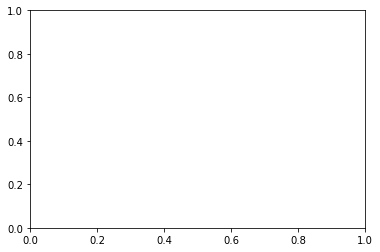

In [157]:
plt.figure()
plt.plot(np.arange(qc.start_yr,qc.stop_yr),sizes)
plt.show()